In [164]:
"""
``autoreload`` is an IPython extension that reloads modules
automatically before executing the line of code typed.
"""

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Timeseries forecasting with ARIMA model

In [165]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [166]:
RAW_DATA_PATH = Path('__file__').resolve().parents[1] / 'data' / '01_raw'
PROCESSED_DATA_PATH = Path('__file__').resolve().parents[1] / 'data' / '02_processed'

In [167]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = [15, 8]

In [168]:
sns.set_style('whitegrid')

In [169]:
def read_and_format_csv(subfolder_path: Path, raw_path: bool = True) -> pd.DataFrame:
    if raw_path:
        path = str(RAW_DATA_PATH / subfolder_path)
        df = pd.read_csv(path)
    else:
        path = str(PROCESSED_DATA_PATH / subfolder_path)
        df = pd.read_csv(path)
        
    
    df = df.astype({col: 'float32' for col in ['Open', 'High', 'Low', 'Close', 'Adj Close',]})
    df['stock_name'] = df['stock_name'].astype('str')
    df['Volume'] = df['Volume'].astype('int32')

    df['Date'] = pd.to_datetime(df['Date'], format='ISO8601', utc='True')
    df['Date'] = pd.to_datetime(df['Date'].dt.date)
    return df

In [170]:
df = read_and_format_csv(subfolder_path='Information_Technology/AAPL.csv', raw_path=True)
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL
2,1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000,AAPL
3,1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600,AAPL
4,1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600,AAPL


In [171]:
df.sort_values(by='Date', inplace=True)
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL
2,1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000,AAPL
3,1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600,AAPL
4,1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600,AAPL


In [172]:
df.dtypes

Date          datetime64[ns]
Adj Close            float32
Close                float32
High                 float32
Low                  float32
Open                 float32
Volume                 int32
stock_name            object
dtype: object

## Notes about the dataset

<ul>
    <li>Horly Dataset</li>
    <li>The currency used is American dollar</li>
    <li>Returns column (below) is percentage daily returns</li>
    <li>Datetime is based on american new york timezone</li>
    <li></li>
</ul>

## Focusing on Daily resolution and returns

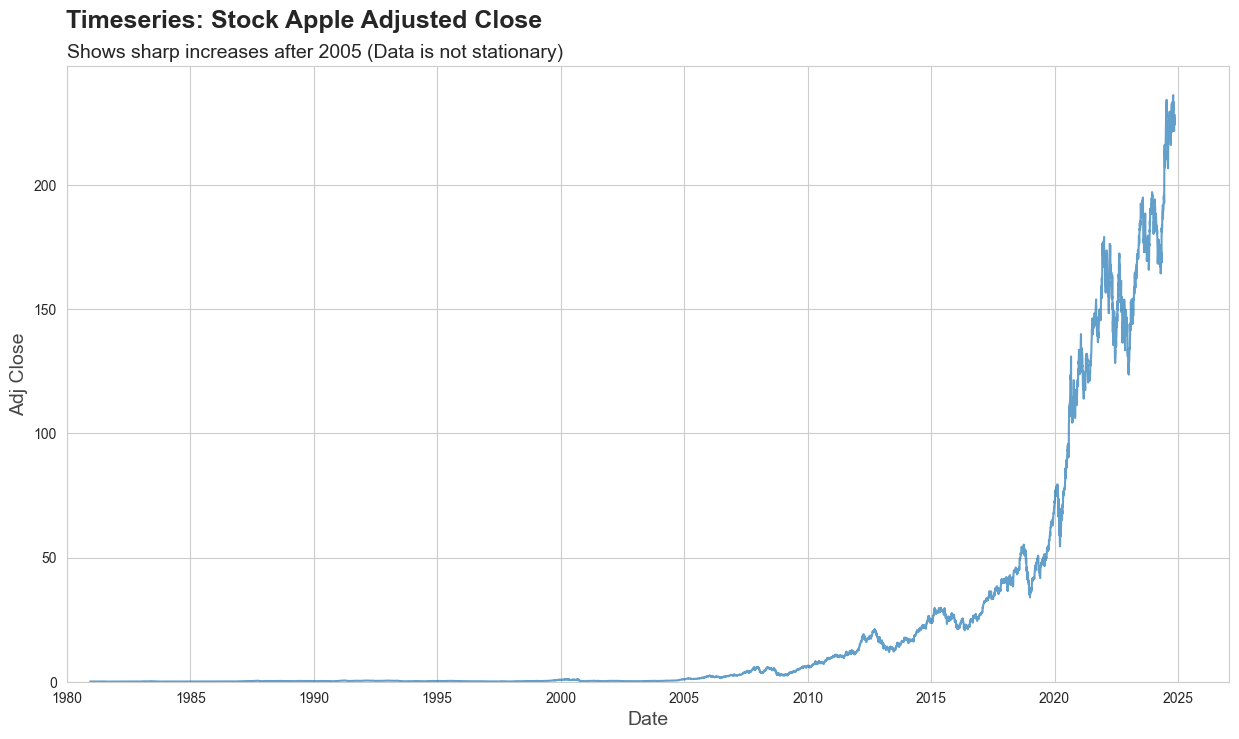

In [173]:
f, ax = plt.subplots(nrows=1, ncols=1,)

sns.lineplot(data=df, x='Date', y='Adj Close', markers='o', alpha=0.7)

ax.set_xlabel('Date', fontsize=14, alpha=0.85)
ax.set_ylabel('Adj Close', fontsize=14, alpha=0.85)

dx, dy = 0.2835, 0.95
f.suptitle(t='Timeseries: Stock Apple Adjusted Close', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Shows sharp increases after 2005 (Data is not stationary)', fontsize=14, loc='left')

ax.set_xlim(df['Date'].min() + timedelta(days=-350))
ax.set_ylim(0)
plt.show()


We can see from this Timeseries that it has Trends but No clearn evidence of seasonality and is definitely not stationary so we need to transform it, I believe I should use first difference or normalised difference (pct change)

### Calculate the first order Difference and returns

In [174]:
df['Returns'] = df['Adj Close'].pct_change()
df['first_diff'] = df['Adj Close'].diff()
df.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff
0,1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600,AAPL,NaN,NaN
1,1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800,AAPL,-0.052171,-0.005156


Stock market contains less data points for 1980 so we start at 1981

In [175]:
df = df.loc[df['Date'].dt.year > pd.Timestamp('1980').year].reset_index(drop=True)
df.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff
0,1981-01-02,0.118602,0.154018,0.155134,0.154018,0.154018,21660800,AAPL,0.010989,0.001289
1,1981-01-05,0.116024,0.150670,0.151228,0.150670,0.151228,35728000,AAPL,-0.021738,-0.002578


In [176]:
df.iloc[:, 1:].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,Adj Close,Close,High,Low,Open,Volume,Returns,first_diff
count,11061.000000,11061.000000,11061.000000,11061.000000,11061.000000,1.106100e+04,11061.000000,11061.000000
mean,22.893742,23.732557,23.969788,23.473480,23.716425,3.025108e+08,0.001077,0.020622
std,48.389786,48.864780,49.337860,48.341076,48.823273,3.215887e+08,0.027785,0.916040
min,0.037815,0.049107,0.049665,0.049107,0.049665,-2.108338e+09,-0.518692,-10.566132
10%,0.103992,0.134487,0.137277,0.132813,0.135045,6.835660e+07,-0.028096,-0.176617
25%,0.243658,0.300781,0.306429,0.292411,0.300223,1.110652e+08,-0.012620,-0.008989
50%,0.442485,0.540179,0.549107,0.531250,0.540179,2.030448e+08,0.000000,0.000000
75%,17.913139,20.999643,21.236429,20.821428,21.079287,3.933552e+08,0.014385,0.014069
90%,87.711876,90.014999,91.250000,88.254997,90.019997,7.011536e+08,0.030815,0.261644
99%,197.054633,198.020004,198.887994,195.934000,197.151996,1.504470e+09,0.077555,3.431161


In [177]:
# check and remove any null values
df.isnull().sum()

Date          0
Adj Close     0
Close         0
High          0
Low           0
Open          0
Volume        0
stock_name    0
Returns       0
first_diff    0
dtype: int64

In [178]:
df.dropna(inplace=True)

### Check the Distribution of all columns for any outliers

In [179]:
df.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'stock_name', 'Returns', 'first_diff'],
      dtype='object')

<Axes: xlabel='first_diff', ylabel='Percent'>

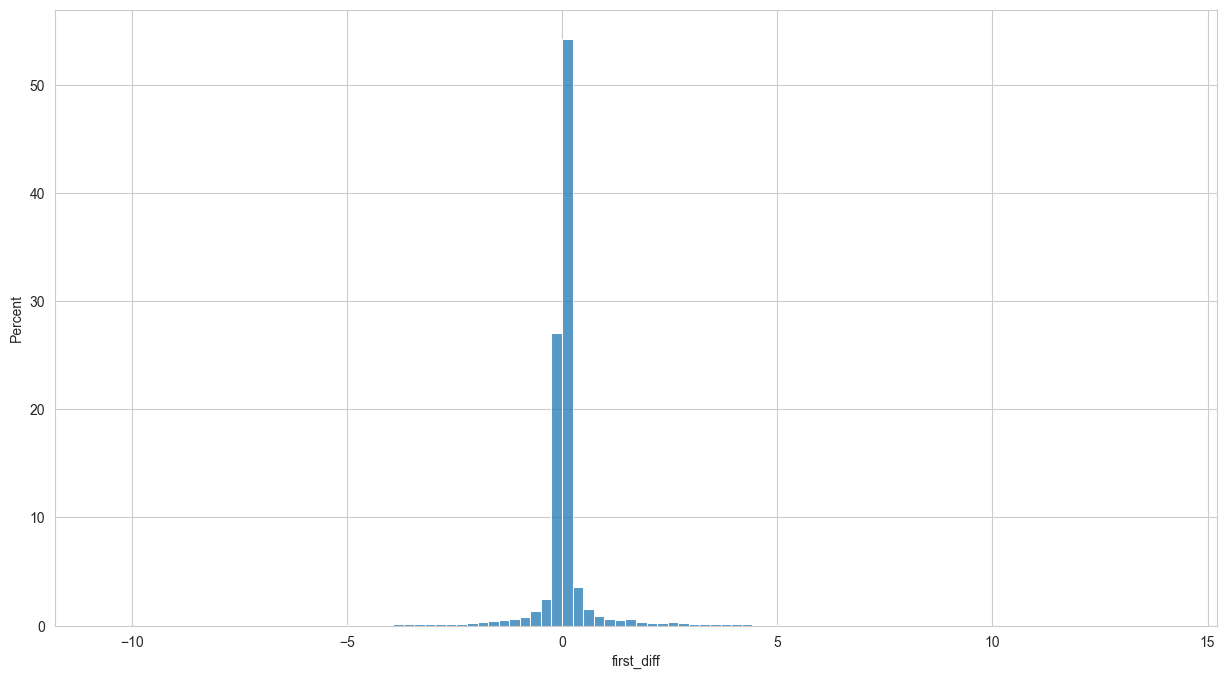

In [180]:
# f, ax = plt.subplots(nrows=9, figsize=(30,30))
# ax = ax.flatten()

# for i, col in enumerate(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume','Returns', 'first_diff']):
#     sns.histplot(df[col], bins=100, ax=ax[i])
sns.histplot(df['first_diff'], bins=100, stat='percent')

<font color=orange size=5>Issue 1: negative volumes, although the negative volumes are wrong the adj close column is still fine

In [181]:
df[df['Volume'] < 0].head()

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff
690,1983-09-23,0.083365,0.108259,0.111607,0.099330,0.111607,-1462621696,AAPL,-0.253844,-0.028361
4196,1997-08-06,0.198177,0.234933,0.247768,0.223214,0.225446,-104487296,AAPL,0.332281,0.049427
4197,1997-08-07,0.219831,0.260603,0.263951,0.253348,0.256696,-539528896,AAPL,0.109265,0.021654
4433,1998-07-16,0.282437,0.334821,0.340402,0.319196,0.338170,-1733616896,AAPL,0.088927,0.023065
4496,1998-10-14,0.281496,0.333705,0.368862,0.328683,0.354911,-2014949696,AAPL,-0.035485,-0.010356


### Looking at abnormal returns when do most of these abnormalities occur

Hypothesis: most of these abnormal negative/positive returns occur during an economic crisis

<font color='orange' size=5>The percentage returns are normally distributed so we want to explore events more than 3 std away from mean to find out when these abnormal events occurred </font>

In [182]:
pct_mean = df['Returns'].mean()
pct_std = df['Returns'].std()

# Calculate z-score
z_score = np.abs((df['Returns'] - pct_mean) / pct_std)

# Find outliers (values more than n_std standard deviations away)
outliers = df[['Date', 'Returns']][z_score > 3]
outliers['Year'] = outliers['Date'].dt.year

In [183]:
outliers

,Date,Returns,Year
63,1981-04-02,0.087632,1981
185,1981-09-25,-0.129776,1981
306,1982-03-19,0.090173,1982
478,1982-11-22,-0.089070,1982
483,1982-11-30,0.103898,1982
...,...,...,...
9884,2020-03-16,-0.128647,2020
9890,2020-03-24,0.100325,2020
9899,2020-04-06,0.087237,2020
9980,2020-07-31,0.104689,2020


<font color=orange size=5>Hypothesis: Lots of abnormal negative returns during recessions and positive after recessions</font> <br>
Inconclusive with daily resolution

In [184]:
abnormal_positive_change = outliers.loc[outliers['Returns'] > 0]
abnormal_negative_change = outliers.loc[outliers['Returns'] < 0]

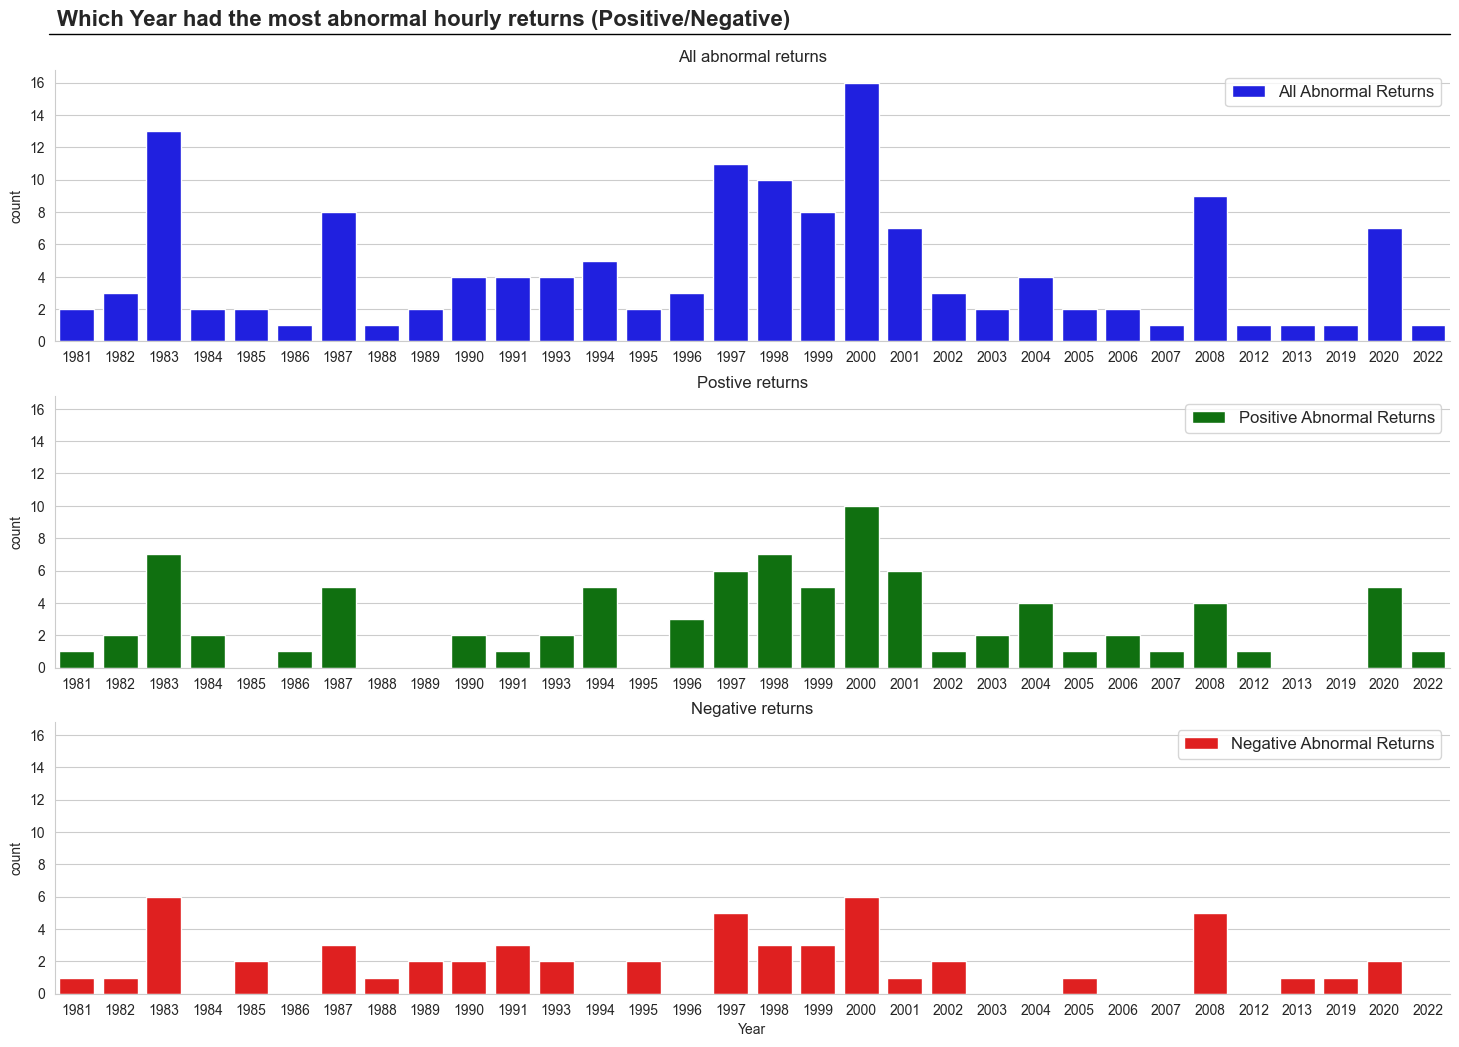

In [185]:
f, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(18, 12))

sns.countplot(data=outliers, x='Year', color='blue', ax=ax[0], label='All Abnormal Returns')
sns.countplot(data=abnormal_positive_change, x='Year', color='green', ax=ax[1], label='Positive Abnormal Returns')
sns.countplot(data=abnormal_negative_change, x='Year', color='red', ax=ax[2], label='Negative Abnormal Returns')

for i, title in enumerate(['All abnormal returns', 'Postive returns', 'Negative returns']):
    ax[i].xaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].set_title(title)
    ax[i].set_xlabel('Year')
    ax[i].legend(loc=0, fontsize=12)
    
sns.despine()
dx, dy = 0.33, 0.93
f.suptitle(t='Which Year had the most abnormal hourly returns (Positive/Negative)', fontsize=16, x=dx, y=dy, weight='bold')
f.add_artist(plt.Line2D([0.122, 0.9], [0.91, 0.91], color='black', linewidth=1))




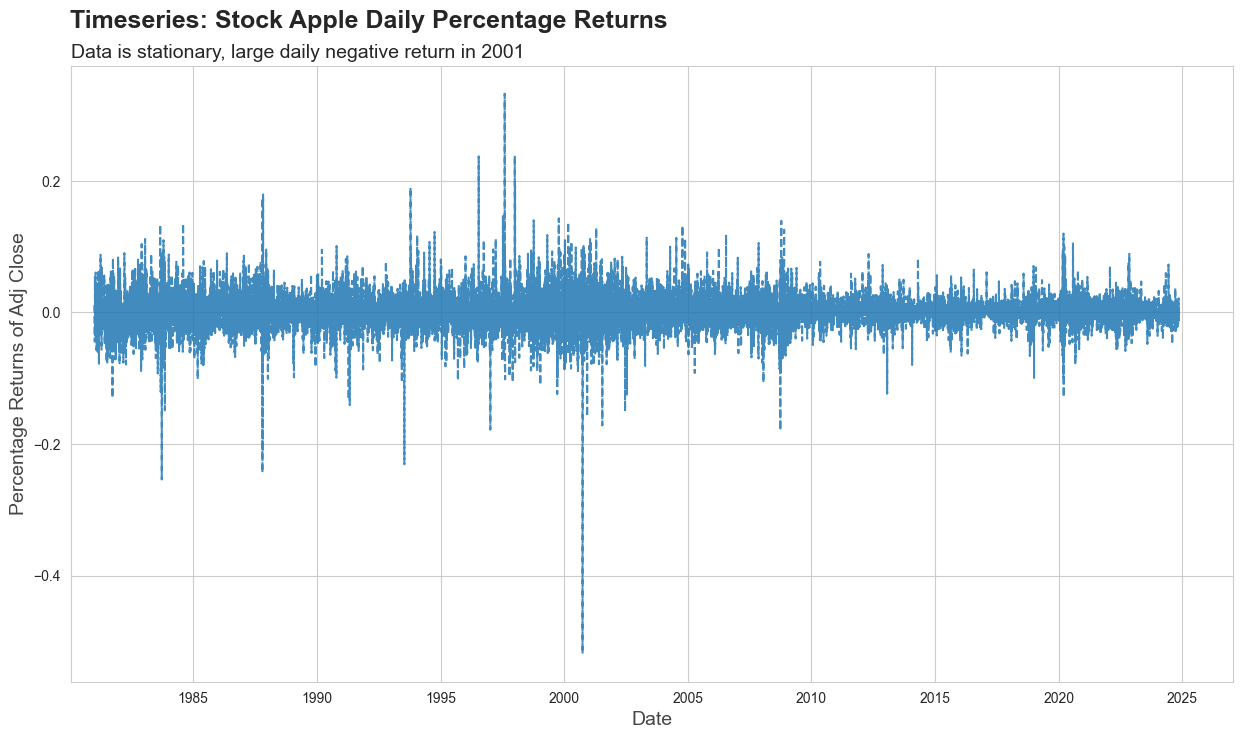

In [186]:
f, ax = plt.subplots()
sns.lineplot(data=df, x='Date', y='Returns', linestyle='--', markers='o', ax=ax, alpha=0.85)


ax.set_xlabel('Date', fontsize=14, alpha=0.85)
ax.set_ylabel('Percentage Returns of Adj Close', fontsize=14, alpha=0.85)

dx, dy = 0.3235, 0.95
f.suptitle(t='Timeseries: Stock Apple Daily Percentage Returns', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Data is stationary, large daily negative return in 2001', fontsize=14, loc='left')

ax.set_xlim(df['Date'].min() + timedelta(days=-350))

plt.show()


Timeseries of Percentage Returns looks stationary and good

Variance changes so should i be concerned?

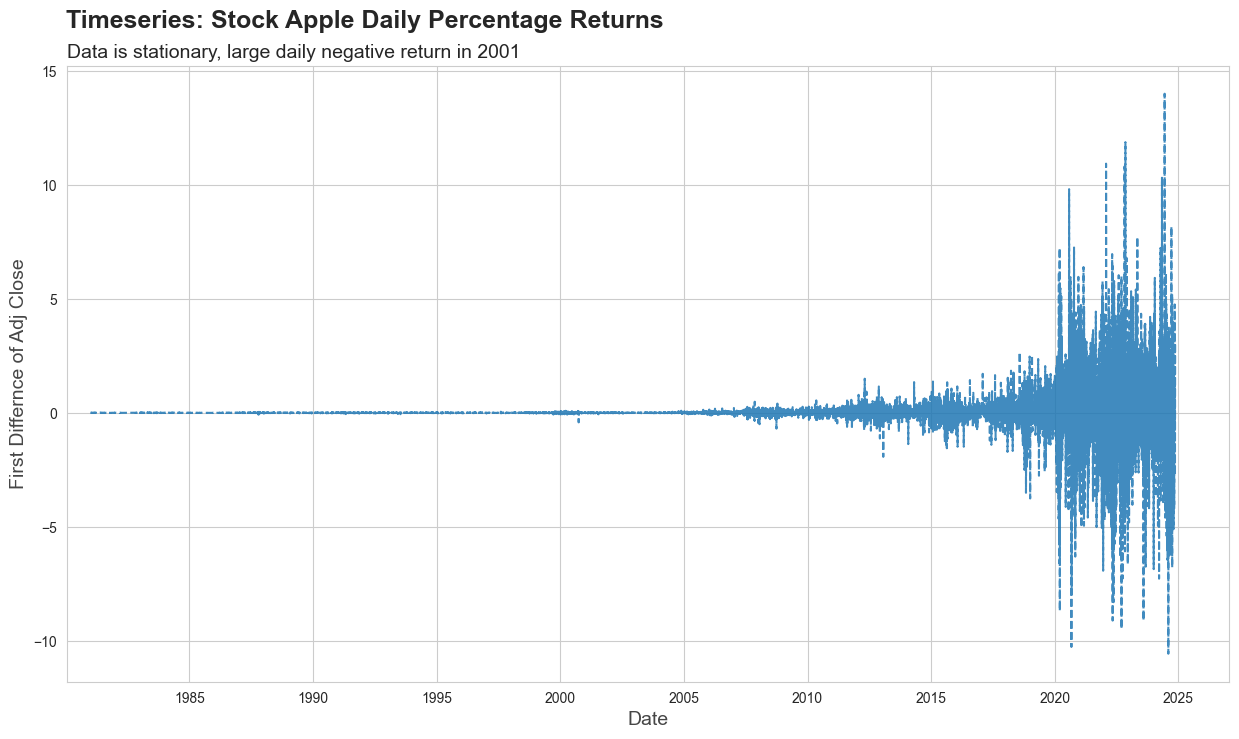

In [187]:
f, ax = plt.subplots()
sns.lineplot(data=df, x='Date', y='first_diff', linestyle='--', markers='o', alpha=0.85)


ax.set_xlabel('Date', fontsize=14, alpha=0.85)
ax.set_ylabel('First Differnce of Adj Close', fontsize=14, alpha=0.85)

dx, dy = 0.3235, 0.95
f.suptitle(t='Timeseries: Stock Apple Daily Percentage Returns', fontsize=18, x=dx, y=dy, fontweight='bold')
ax.set_title(label='Data is stationary, large daily negative return in 2001', fontsize=14, loc='left')

ax.set_xlim(df['Date'].min() + timedelta(days=-350))
plt.show()

Graph of timeseries First diffrence Adjusted Close difference also looks stationary

---

### Augmented Dickey Fuller Test

In order to use an ARIMA model our data should be stationaly therefore having an normal distribution around the mean and should have no significant changes in the volatility or fluctuations of the data over different time periods. <br>

Therefore we run the Adfuller test, which is a statistical test for stationarity. It works by testing the null hypothesis on a sample that the timeseries in not stationary. Returning test statistics and p-value and Critical values.

In [188]:
from statsmodels.tsa.stattools import adfuller

In [189]:
# First Difference adj close results in really small p_value 3.5*10-30
results = adfuller(df['Returns'])
results

(np.float64(-30.002091222511435),
 0.0,
 11,
 11049,
 {'1%': np.float64(-3.4309419829743115),
  '5%': np.float64(-2.861801623995844),
  '10%': np.float64(-2.566909257329274)},
 np.float64(-47752.58355187107))

In [190]:
# pct change adj close results in p-value of 0
results = adfuller(df['first_diff'])
results

(np.float64(-17.72607265560365),
 np.float64(3.4513273352450356e-30),
 39,
 11021,
 {'1%': np.float64(-3.430943487319322),
  '5%': np.float64(-2.861802288767382),
  '10%': np.float64(-2.5669096111856504)},
 np.float64(29191.227878541777))

Good p-values and visuallising the graph makes me convinced that this is good for ARIMA

---

### Spliting data into train and test set

In [191]:
df.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume,stock_name,Returns,first_diff
0,1981-01-02,0.118602,0.154018,0.155134,0.154018,0.154018,21660800,AAPL,0.010989,0.001289
1,1981-01-05,0.116024,0.150670,0.151228,0.150670,0.151228,35728000,AAPL,-0.021738,-0.002578


Use 10,000 rows for modelling

In [192]:
rows = 10_000

In [193]:
df_arima = df.iloc[:rows, [0, -2]]
df_arima.shape

(10000, 2)

In [194]:
df_arima.set_index('Date', inplace=True)

In [195]:
rows_training = int(rows * 0.8)
training = df_arima.iloc[:rows_training]
testing = df_arima.iloc[rows_training:]

---

### ARIMA Modelling

#### General Arima model with random p and q values

In [196]:
from statsmodels.tsa.arima.model import ARIMA

In [197]:
p = 5
q = 5

model = ARIMA(training, order=(p,0,q))
results = model.fit()

In [198]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 8000
Model:                 ARIMA(5, 0, 5)   Log Likelihood               16512.863
Date:                Tue, 26 Nov 2024   AIC                         -33001.726
Time:                        13:41:04   BIC                         -32917.879
Sample:                             0   HQIC                        -32973.027
                               - 8000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      3.249      0.001       0.000       0.002
ar.L1          0.0121      0.026      0.458      0.647      -0.040       0.064
ar.L2         -0.0134      1.600     -0.008      0.9

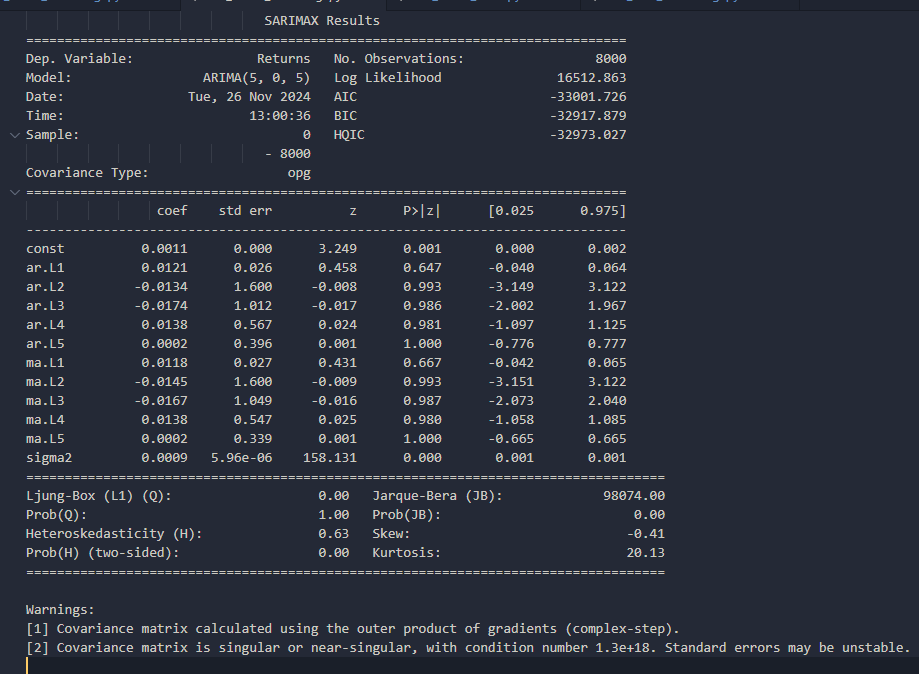

First model with random p and q values seem to give a low AIC and BIC value which is a good sign, Prob Q and Prob JB ask Todd

In [199]:
# results.resid

Figure(1500x800)


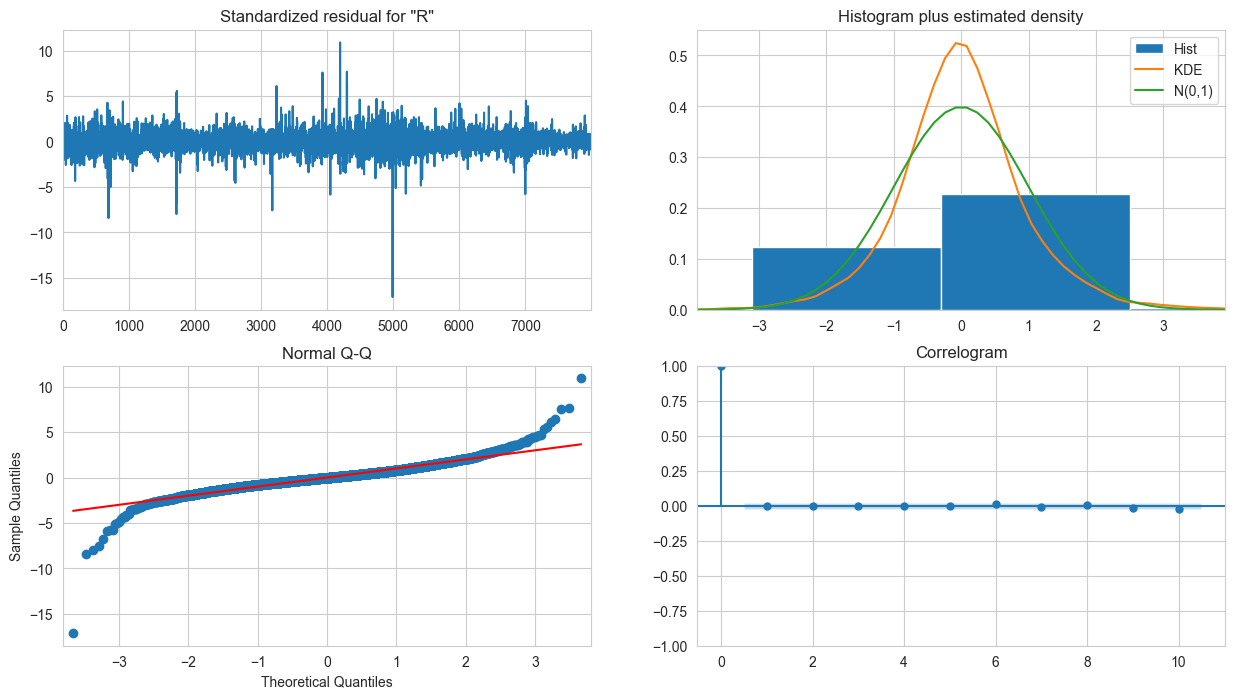

In [200]:
print(results.plot_diagnostics())

In [201]:
forecast = results.get_prediction(start='2001-05-01', end='2002-05-01')
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [202]:
prediction_slice = prediction_slice = training.loc['2001-05-01':'2002-05-01']
prediction_slice.head(2)

,Returns
Date,
2001-05-01,0.017261
2001-05-02,0.025452


p q > 5 are usually large, risk of overfitting with larger values <br>
instead of may train upto July extended training periods

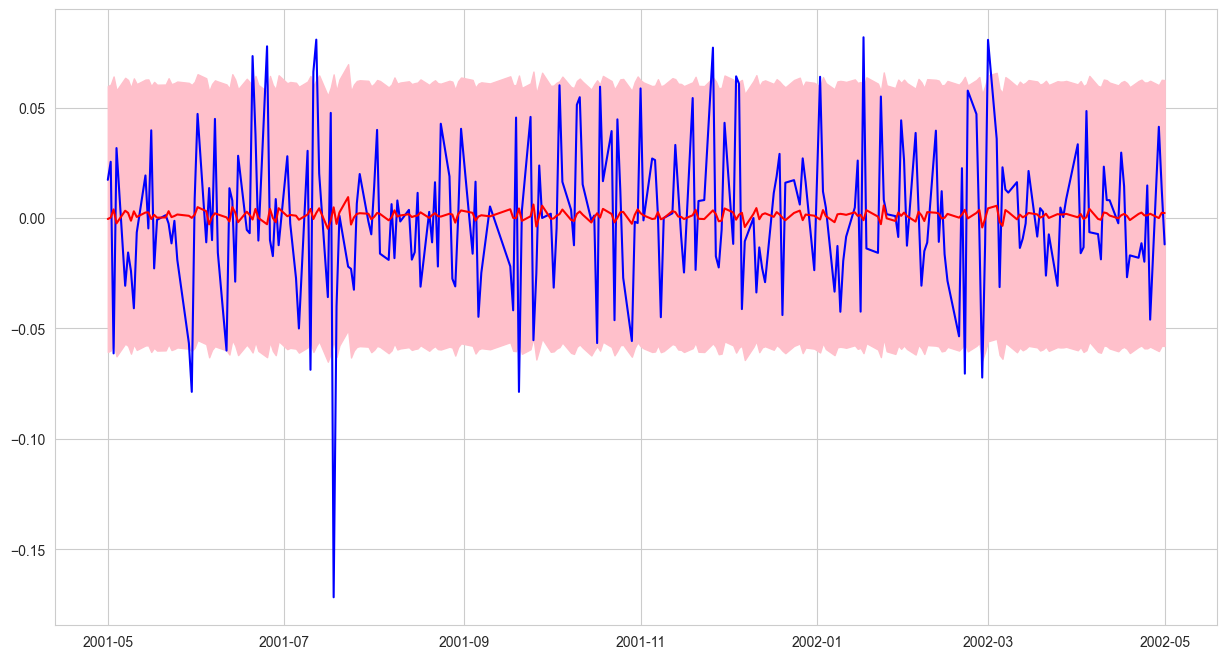

In [203]:
plt.figure()

plt.plot(prediction_slice, color='blue')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
plt.fill_between(mean_forecast.index, confidence_intervals['lower Returns'], confidence_intervals['upper Returns'], color='pink')

---

### Find optimal model lags and moving average compenents

Takes a long time as tries a combination of p and q values and finds the lowest AIC and BIC score

In [204]:
# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# from pathlib import Path

# import warnings

# import time
# from tqdm import tqdm
# import sys

# warnings.filterwarnings("ignore")


# RAW_DATA_PATH = Path("__file__").resolve().parents[0] / "data" / "01_raw"
# PROCESSED_DATA_PATH = Path("__file__").resolve().parents[0] / "data" / "02_processed"
# MODEL_OUT_PATH = Path("__file__").resolve().parents[0] / "models"


# def print_timer(seconds):
#     sys.stdout.write(f"\rElapsed Time: {seconds:.2f} seconds")
#     sys.stdout.flush()


# def read_and_format_csv(subfolder_path: Path, raw_path: bool = True) -> pd.DataFrame:
#     if raw_path:
#         path = str(RAW_DATA_PATH / subfolder_path)
#         df = pd.read_csv(path)
#     else:
#         path = str(PROCESSED_DATA_PATH / subfolder_path)
#         df = pd.read_csv(path)

#     df = df.astype(
#         {
#             col: "float32"
#             for col in [
#                 "Open",
#                 "High",
#                 "Low",
#                 "Close",
#                 "Adj Close",
#             ]
#         }
#     )
#     df["stock_name"] = df["stock_name"].astype("str")
#     df["Volume"] = df["Volume"].astype("int32")

#     df["Date"] = pd.to_datetime(df["Date"], format="ISO8601", utc="True")
#     df["Date"] = pd.to_datetime(df["Date"].dt.date)
#     return df


# df = read_and_format_csv(
#     subfolder_path="Information_Technology/AAPL.csv", raw_path=True
# )

# df["Returns"] = df["Adj Close"].pct_change()
# df = df[["Date", "Returns"]].dropna().set_index("Date")

# num_args_p, num_args_q = (27, 54), (27, 54)

# order_ai_bic = []
# total_start = time.time()
# total_iterations = (num_args_p[1] - num_args_p[0]) * (num_args_q[1] - num_args_q[0])

# with tqdm(total=total_iterations, desc="Fitting ARIMA Models") as pbar:
#     for p in range(num_args_p[0], num_args_p[1]):
#         # Loop over MA order
#         for q in range(num_args_q[0], num_args_q[1]):
#             try:
#                 start_time = time.time()
#                 # Fit model
#                 model = ARIMA(df, order=(p, 0, q))
#                 results = model.fit()
#                 # Print the model order and the AIC/BIC values
#                 order_ai_bic.append((p, q, results.aic, results.bic))

#                 elapsed = time.time() - start_time
#                 print_timer(elapsed)

#             except:
#                 # Print AIC and BIC as None when fails
#                 print(p, q, None, None)
#             pbar.update(1)
#     total_time = time.time() - total_start
#     print(f"\nTotal execution time: {total_time:.2f} seconds")


# order_df = pd.DataFrame(order_ai_bic, columns=["p", "q", "aic", "bic"])
# order_df.to_csv(
#     str(MODEL_OUT_PATH / f"arima_order_aic_bic_{num_args_p[0]}_{num_args_p[1]}.csv"),
#     index=0,
# )


---

### Monthly Resolution and Returns

In [218]:
# The best model p and q values between 729 combination are (1, 0, 12)
p = 1
q = 12

model = ARIMA(training, order=(p,0,q))
results = model.fit()

In [233]:
df.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'stock_name', 'Returns', 'first_diff'],
      dtype='object')

In [219]:
training.shape

(8000, 1)

In [220]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 8000
Model:                ARIMA(1, 0, 12)   Log Likelihood               16523.447
Date:                Tue, 26 Nov 2024   AIC                         -33016.894
Time:                        13:42:55   BIC                         -32912.086
Sample:                             0   HQIC                        -32981.020
                               - 8000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      3.148      0.002       0.000       0.002
ar.L1          0.2265      0.246      0.920      0.357      -0.256       0.709
ma.L1         -0.2042      0.246     -0.830      0.4

Figure(1500x800)


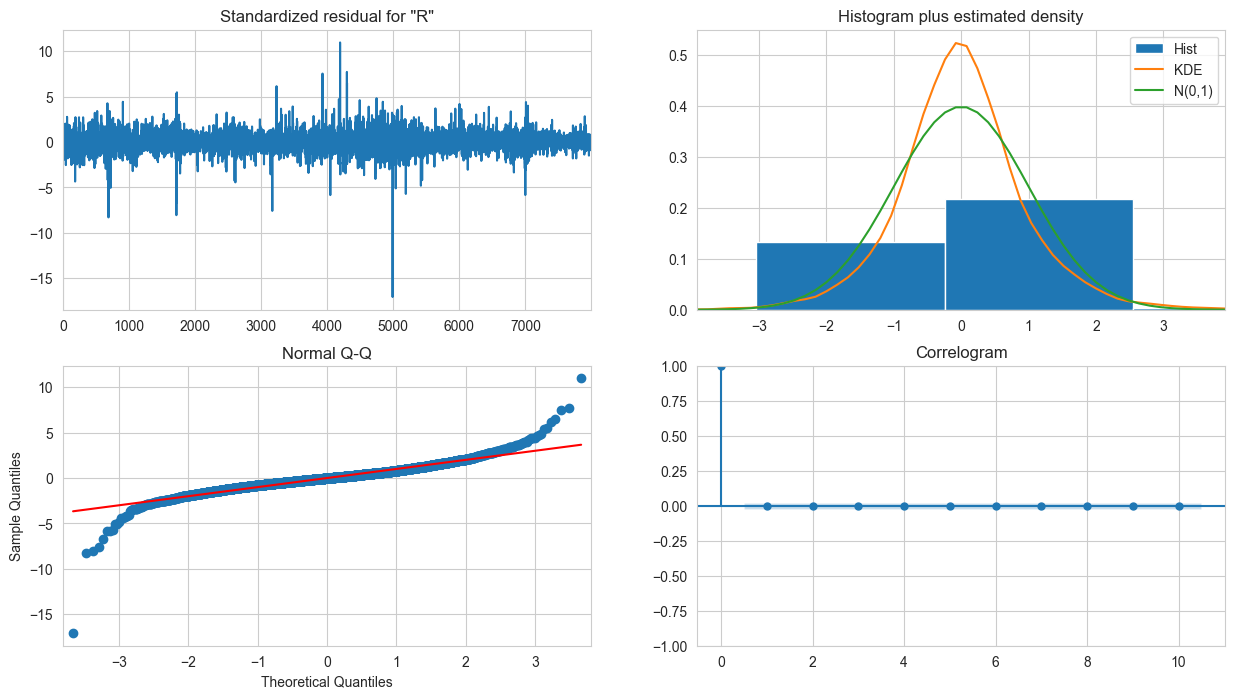

In [221]:
print(results.plot_diagnostics())

Good model corifident somewhat?

In [228]:
df['Returns'].head()

0    0.010989
1   -0.021738
2   -0.044448
3   -0.042633
4   -0.020241
Name: Returns, dtype: float32

In [222]:
residuals = results.resid
mae = results.mae
rmse = np.sqrt(results.mse)
rmse, mae

(np.float64(0.030673096789344382), np.float64(0.02155962250966263))

---

ARIMA with (p,1,q) pram

---

Auto arima time definetly!!!

In [223]:
df.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'stock_name', 'Returns', 'first_diff'],
      dtype='object')

---